In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import sys
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (LabelEncoder, FunctionTransformer,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV)
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, precision_score,
                             make_scorer)
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from itertools import combinations
from xgboost import XGBClassifier

%matplotlib inline

## Overview

Pandemics have occured throughout history, each time affecting a large portion of the population. The most recent case being the Covid-19 2020 outbreak which resulted in a prolonged change in peoples day to day life, a lack or resources, and ultimately many deaths all around the world. If possible governments will do their best to try and prevent any future outbreaks by observing and learning from past information.     

Therefore our stakeholder, a government agency, is trying to plan for future pandemic prevention and awareness by using the 2009 H1N1 pandemic as an example. They would like us to observe which features of a survey completed at the time appear to hold the highest importance in people who did not recieve the H1N1 vaccine. With this information they are hoping to be able to concentrate their efforts to provide vaccination information and flu prevention methods to a group that was otherwise more succeptible to contracting the virus. These efforts will be performed in hopes of increasing the vaccination rates and to help limit the spread of future viruses.

---

## Business Understanding

1. Determine business objectives: You should first “thoroughly understand, from a business perspective, what the customer really wants to accomplish.” (CRISP-DM Guide) and then define business success criteria.
2. Assess situation: Determine resources availability, project requirements, assess risks and contingencies, and conduct a cost-benefit analysis.
3. Determine data mining goals: In addition to defining the business objectives, you should also define what success looks like from a technical data mining perspective.
4. Produce project plan: Select technologies and tools and define detailed plans for each project phase.

Our stakeholders goal is to help in the prevention of future pandemics by spreading vaccination and prevention information. To increase the value of their efforts they would like to target the population that are less inclined to receive the vaccination. The most successful outcome would be the prevention of a widespread outbreak resulting in a pandemic, but more realisticly an increase in vaccination awareness that results in a higher rate of people receiving vaccinations in case another outbreak occurs.

Therefore this projects requirements are to define the target audience who are less inclined to receive a vaccination. In order to do so a data on people who have both received and refrained from receiving vaccinations in the past is required. Available to us is a survey conducted for the 2009 H1N1 pandemic. The H1N1 outbreak was first detected in the United States and quickly spread across the rest of the world resuliting in between 151,000 and 575,000 deaths worldwide. Unlike prior strains of the H1N1 virus, people under 65 were more affected than the older population. Around 80 percent of the deaths assumed caused by this strain of H1N1 were people under the age of 65. Since this strain differend from previous strains the seasonal flu vaccinations didn't offer protection from the virus causing a late production of a vaccine that would be affective. An affective vaccination didn't get mass produced until after a second wave of the virus had come and gone in the United States <a href="#h1n1_cdc_article">[1]</a>.

Due to these factors this dataset may stray from a typical case, reason being: 

1. <strong>The late emergence of the mass produced vaccine.</strong> It wasn't until after the second outbreak had passed that it was available, possibly causing people to assume the worst was over and a vaccination wasn't required and lowering the number of vaccinations.

2. <strong>The age group most affected were people under 65.</strong> This isn't typical for outbreaks and may have caused the number of vaccinations in this age group to be inflated.

Though our dataset may not reflect these two points, they should be kept in mind while analyzing the results. As far as metrics to qualify our models performance, I believe accuracy and precision should be used. A result of having high precision will ensure that our feature importance will strongly relate to true positive entries. Though there should be a fine balance and recall shouldn't be completely forgone. While we don't want our predicted positives to contain many false positives, we would like to predict a good portion of out true positive entries. By approaching our problem by utilizing our metrics in this manner we can assure that our stakeholder is targeting the correct audience.


---

## Data Understanding

As mentioned earlier in the business understanding section, the data being used for this analysis will be a 2009 survey conducted for the H1N1 outbreak. This survey was performed by the CDC in order to monitor and evaluate the flu vaccination efforts amount adults and children. The participants were parts of randomly called US households. The questions asked the participants dealt with their H1N1 vaccination status, flu-related behaviors, opinions about flue vaccine safety and effectivenss, recent respiratory illness, and pneumococcal vaccination status <a href="#About the National Immunization Survery">[2]</a>.

A detailed explanation of the features included in this survey can be found <a href="https://github.com/cschneck7/phase_3_project/blob/main/data/H1N1%20and%20Seasonal%20Flu%20Vaccines%20Feature%20Information.txt">here</a> or <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/">here</a>.
<!--  link need to fitted to github repository when pushed -->

After observing the column descriptions and values linked above, most of the features can be considered categorical. The only features that don't seem to be categorical are the opinion based one with 5 discrete values from 1-5, but in an order of ranking. Therefore these will be left alone and not One Hot Encoded.   

The following data from the survey can be found and downloaded <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/data/">here</a> <a href="#Source Data Download">[3]</a>

In [2]:
# Import survey data into dataframes
# The source dataset already had this split feature and target files
X = pd.read_csv('data/source_data/training_set_features.csv')
y = pd.read_csv('data/source_data/training_set_labels.csv')

The `training_set_labels.csv` file read to `y` contains two target variables, `h1n1_vaccine` and `seasonal_vaccine1`. For this project only the `h1n1_vaccine` target variable will be used.

In [3]:
# Sets target variable
y = y.h1n1_vaccine

In [4]:
# Checks distribution of target variable
print(y.value_counts())
print(y.value_counts(normalize=True))

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


Around 79% of those who were surveyed did not receive the vaccination. 

Let't take a look at the featuers.

In [5]:
# preview of feature dataframe
X.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


We don't need the `respondent_id` column, so it will be dropped.

In [6]:
# drops respondent_id column
X.drop('respondent_id', axis=1, inplace=True)

# preview at feature column information
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

This datasets contains 26,707 entries and 35 features. The features have been inputted as either float64 or object types, 23 and 12 columns of those types respectively. As mentioned in the <a href="https://github.com/cschneck7/phase_3_project/blob/main/data/H1N1%20and%20Seasonal%20Flu%20Vaccines%20Feature%20Information.txt">feature description</a> file, the float64 column types are either encoded or binary where Yes=1 and No=0. It can also be observed from the above information that there are many missing values.

In [7]:
# Checks amount of Nan values in feature dataframe
missing_values = X.isna().sum()
missing_values

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

Almost all columns are missing values, and some are missing nearly half of their values missing. These columns may be dropped later while the others are filled in. 

In [8]:
# Saving columns with many missing entries for later
many_missing = missing_values[missing_values > 12000]

Now lets check correlation between our target variable and features. We will be using a Chi2 test, with alpha=.05 and our null hypothesis being that there is no relationship between our feature and target variable.

Hypothesis:<br><br>
&emsp;&emsp;<strong>H<sub>0</sub></strong>: No relationship between the feature and target variable
<br>
&emsp;&emsp;<strong>H<sub>1</sub></strong>: There is a relationship between the feature and target variable   

In [9]:
def ordered_chi2(features, target='features', ascending=True, alpha=None):
    '''
    Returnes the ordered chi2 P-values between each feature and the target variable or variables
    
    Inputs: features = Dataframe of features
            target = pd.Series as target or default = 'features' which results in 
            finding relationships inside features DataFrame
            ascending = Determines order, default value = True
            alpha = Chi2 Pvalue threshold for which features get returned.
                        Returns all features with a Pvalue<=alpha,
                        default = None so all features are returned
            
    Output: Dataframe containing ordered P-values
    '''
    
    df = pd.DataFrame(columns=['var1', 'var2', 'Pvalue'])
                 
    if isinstance(target, pd.Series):
        for col in features.columns:
            temp_dict={}
            temp_dict['var1'] = target.name
            temp_dict['var2'] = col
            temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(target, features[col]))[1]
            df = df.append(temp_dict, ignore_index=True)
    
    elif target == 'features':
        combs = combinations(features.columns, 2)
        for comb in combs:
            temp_dict={}
            temp_dict['var1'] = comb[0]
            temp_dict['var2'] = comb[1]
            temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(features[comb[0]], features[comb[1]]))[1]
            df = df.append(temp_dict, ignore_index=True)
        
    else:
        sys.exit('''Incorrect input for parameter target.
        Parameter only accepts types pd.DataFrame, pd.Series, or left to default value.''')        
    
    if alpha == None:
        return df.sort_values(by='Pvalue', ascending=ascending)
    else:
        return df[df.Pvalue <= alpha].sort_values(by='Pvalue', ascending=ascending)

In [10]:
ordered_chi2(X, y)

,var1,var2,Pvalue
19,h1n1_vaccine,opinion_seas_risk,0.000000e+00
16,h1n1_vaccine,opinion_h1n1_risk,0.000000e+00
15,h1n1_vaccine,opinion_h1n1_vacc_effective,0.000000e+00
9,h1n1_vaccine,doctor_recc_h1n1,0.000000e+00
10,h1n1_vaccine,doctor_recc_seasonal,7.176678e-237
18,h1n1_vaccine,opinion_seas_vacc_effective,1.719836e-218
33,h1n1_vaccine,employment_industry,5.786809e-175
34,h1n1_vaccine,employment_occupation,2.021881e-172
13,h1n1_vaccine,health_worker,4.345311e-164
1,h1n1_vaccine,h1n1_knowledge,8.631658e-87


The above dataframe tells us that all but two features have failed the null hypothesis (H<sub>0</sub>) and are significant to our target variable. The two features that ended up being insignificant are `household_children` and `census_msa`.

The top six features in terms of significance were:

- `opinion_seas_risk`
- `opinion_h1n1_risk`
- `opinion_h1n1_vacc_effective`
- `doctor_recc_h1n1`
- `doctor_recc_seasonal`
- `opinion_seas_vacc_effective`

A theme of the top six is that there are basically three topics, asked each about the H1N1 flu and Seasonal flu. The initial assumption is that these pairs may be highly correlated. Let's confirm this by checking the correlation of all features using the Chi2 test again with an alpha of .05. The hypothesis are similar to the previous test between features and target variable.

Hypothesis:<br><br>
&emsp;&emsp;<strong>H<sub>0</sub></strong>: No relationship between the two features
<br>
&emsp;&emsp;<strong>H<sub>1</sub></strong>: There is a relationship between the two features 

In [11]:
alpha=.05
chi2_df = ordered_chi2(X, alpha=alpha)
chi2_df

,var1,var2,Pvalue
594,employment_industry,employment_occupation,0.000000
534,race,hhs_geo_region,0.000000
383,health_worker,employment_industry,0.000000
528,education,employment_occupation,0.000000
527,education,employment_industry,0.000000
...,...,...,...
347,child_under_6_months,opinion_seas_vacc_effective,0.030892
123,behavioral_avoidance,employment_status,0.035881
90,behavioral_antiviral_meds,marital_status,0.042447
376,health_worker,marital_status,0.044544


According to the DataFrame above, many features are correlated. There are a total of 573 instances of high correlation between features. Considering we have many missing values to deal with, the high correlation between certain features may help us fill in some missing data. Let's check if our assumption about the questions related to both the H1N1 and Seasonal flu having high multicollinearty is true.

In [54]:
similar_features = [['doctor_recc_h1n1', 'doctor_recc_seasonal'],
                    ['opinion_h1n1_vacc_effective', 'opinion_seas_vacc_effective'],
                    ['opinion_h1n1_risk', 'opinion_seas_risk'],
                    ['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']]

for pair in similar_features:
    pvalue = "{:e}".format(float(chi2_df.loc[((chi2_df.var1 == pair[0]) & (chi2_df.var2 == pair[1])) |
                ((chi2_df.var2 == pair[0]) & (chi2_df.var1 == pair[1])), 'Pvalue']))
    print(f'({pair[0]}, {pair[1]}) : {pvalue}')

(doctor_recc_h1n1, doctor_recc_seasonal) : 0.000000e+00
(opinion_h1n1_vacc_effective, opinion_seas_vacc_effective) : 0.000000e+00
(opinion_h1n1_risk, opinion_seas_risk) : 0.000000e+00
(opinion_h1n1_sick_from_vacc, opinion_seas_sick_from_vacc) : 0.000000e+00


As seen above our assumptions were correct, for all cases we can reject the null hypothesis of the features having no relationship.

## Data Preparation

Now that we have a better understanding of our data, let's prepare it for our models. 

We'll start with dropping columns and row containing many missing entries. We already found the columns that fit this criteria earlier. While we are performing this all duplicate entries will be dropped.

In [12]:
X_prep = X.copy()

X_prep.drop(many_missing.index, axis=1, inplace=True)

# Drops duplicate entries if any exist
df_all = pd.concat([X_prep, y], axis=1).drop_duplicates()
X_prep = df_all.drop(y.name, axis=1)
y_prep = df_all[y.name]

print(f'Original number of entries: {X.shape[0]}')
print(f'Number of entries after dropped Duplicates: {X_prep.shape[0]}')

Original number of entries: 26707
Number of entries after dropped Duplicates: 26707


There weren't any duplicate entries.

Before we start editing more values and rows lets create a train-test split to prevent data leakage.

In [13]:
# Creates training and test splits to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=.25, random_state=42)

Now lets check how many rows are missing many values.

In [14]:
def missing_row_entries(df):
    '''
    Prints a DataFrame where:
        index = num of nan entries in a row
        frequency = number of rows with amount of nans defined by index
        cum_sum = cumulative sum starting with rows with most missing entries
        
    inputs: df = DataFrame with missing entries
    output: DataFrame, with nan per row information
    '''
    
    # Creates a list with number of missing values in each row
    nan_per_row = []
    for i in range(df.shape[0]):
        nan_per_row.append(df.iloc[i,:].isna().sum())
       
    # creates dataseries of missing values
    nan_per_row_ds = pd.Series(nan_per_row)
    nan_per_row_ds.rename('frequency', inplace=True)
    
    # gets frequeny of nan amounts in rows
    nan_row_counts = nan_per_row_ds.value_counts()
    
#     Orders nan_row_counts descending by most nans down
    ordered_missing_nan = nan_row_counts[nan_row_counts.keys().sort_values(ascending=False)]
    
#     Creates dataseries with cumulative sum
    nan_cum_sum = np.cumsum(ordered_missing_nan)   
    nan_cum_sum.rename('cum_sum', inplace=True)
    
#     Creates DataFrame with rows per missing values amount, and cum sum
    nan_df = pd.concat([ordered_missing_nan, nan_cum_sum], axis=1)
    nan_df.rename_axis('num_of_nans_in_row', inplace=True)
    
    return nan_df

In [15]:
# Find row missing nan information
missing_row_entries(X_train)

,frequency,cum_sum
num_of_nans_in_row,,
19,2,2
18,32,34
17,11,45
16,103,148
15,13,161
14,90,251
13,28,279
12,35,314
11,39,353


Our current features dataframe has 32 features after dropping those four columns. That means around 353 entries are missing about a third (11 values) of their features information. Since these entries are missing most of their information lets drop them from the dataset.

In [16]:
def drop_rows_by_nans(df, y, nan_threshold=None):
    '''
    Drop rows by quantity of nan values with nan_threshold as cut-off point
    
    Inputs: 
            df = DataFrame to be altered, should contain features and target concatenated together
            y = target variable column name
            nan_threshold = cut-off point to drop rows, default = None which results in a value
                            of half or a little larger than number of features
    
    Outputs: 
            feature_df = feature DataFrame
            y = Target Variable
    '''
    
#     Checks value of nan_threshold
    if nan_threshold == None:
#         Sets to half of or rounded up from half of feature columns
        nan_threshold = math.ceil((len(df.columns)-1)/2)
    
#     Finds nans contained in each row 
    nan_per_row = []
    for i in range(df.shape[0]):
        nan_per_row.append(df.iloc[i,:].isna().sum())
    
#     Creates temporary column in df for number of nan values
    df['nans'] = nan_per_row
#     Creates dataframe of rows under nan threshold
    df = df[df.nans < nan_threshold]
#     Creates target variable
    y = df.h1n1_vaccine
#     returns tuple (feature_df, target)
    return (df.drop(['nans', 'h1n1_vaccine'], axis=1), y)

In [17]:
# Creates custom fuction transfromer
Many_Nans_Row_Drop_FT = FunctionTransformer(drop_rows_by_nans, kw_args = {'y': 'h1n1_vaccine',
                                                                          'nan_threshold': 11})

In [18]:
# Creates training set of both features and target to be transformed
train_df = pd.concat([X_train, y_train], axis=1).copy()

# Transforms training set
X_train_mod, y_train_mod = Many_Nans_Row_Drop_FT.fit_transform(train_df)

# Checks change in shape to ensure proper amount of entries were dropped
X_train.shape[0] - X_train_mod.shape[0]

353

Let's now try and fill in the rest of our missing values. Earlier we noticed that many variables had high colinearity with each other, we can use this to help us fill in for missing values. Our first attempt at filling the values will be through classification using the other features.

Issue with this process is the existence of missing values, many models in scikit-learn libraries cannot handle Nan values. Therefore random imputation will be used to fill in the feature information. The values will be randomly selected using existing values and their rate of appearances in the features existing values. After that is completed an iterative Decision Tree Classifier will be used to fill the randomly imputed values with predicted values.

This process was modified from Shashanka Subrahmanya's process for a regression model in his article <a href="https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression">Missing Data Imputation using Regression</a> <a href='#Missing Data Imputation using Regression'>[4]</a>. His process utilized linear regression and didn't create custom transfomers. For the purpose of this project I have modified it to fit my needs.

In [19]:
class RandomImputer(BaseEstimator, TransformerMixin):
    '''
    Randomly imputes values for missing data in new columns.
    Values are based off of existing values and rates of occurences.
    
    Initialized with optional parameter columns which mark which
    columns will be transformed, if left to default value 'all', all
    columns with missing values will be filled.
    '''
    
#     Initializes class object
    def __init__(self, missing_columns='all_missing_columns'):
        self.missing_columns = missing_columns

#     If columns equals all_missing_columns sets attribute to all missing columns 
    def fit(self, X, y=None):
        if self.missing_columns == 'all_missing_columns':
            nan_amount = X.isna().sum()
            self.missing_columns = list(nan_amount[nan_amount>0].index)
#     Handles if single column entered as string
        elif type(self.missing_columns) == str:
            self.missing_columns = [self.missing_columns]
        
        feature_value_info = {}
        for col in self.missing_columns:
            feature_value_info[col] = X.loc[X[col].notnull(), col].value_counts(normalize=True)
            
        self.feature_value_info = feature_value_info
        return self
            
    
    def transform(self, X, y=None):
#         Sets random seed for random seed generation for iterative
#         calls to random.choice in for loop
        np.random.seed(7337)
#         random seeds generation for for loop
        rand_seeds = np.random.randint(0, 10e3, len(self.missing_columns), 'int64')
        
        df = X.copy()
        
        for i, col in enumerate(self.missing_columns):
#     Creates copy of column to have calues imputed into
            df[col+'_imp'] = df[col]
#     Finds number of missing values in column
            number_missing = df[col].isnull().sum()
#     Sets random seed for random.choice
            np.random.seed(rand_seeds[i])
#     Randomly Imputes observed values replacing all missing information
            df.loc[df[col].isnull(), col+'_imp'] = np.random.choice(self.feature_value_info[col].index, 
                                                                    number_missing, 
                                                                    replace = True,
                                                                    p = self.feature_value_info[col])

#     Creates column index variable to be called to set DataFrame index
        self.features_out = df.columns
        
        return df
    
#     Returns final columns index
    def get_features_out(self):
        return self.features_out

This next cell will create a RandomImputer object, fit and transform it to our training feature dataset, and then check if all the missing values have been filled.

In [20]:
# Creates class object
rand_imp = RandomImputer()

# Fits and transforms dataset
X_train_imp = rand_imp.fit_transform(X_train_mod)

# checks if all columns besides original columns with missing data are filled in
X_train_imp.drop(rand_imp.missing_columns, axis=1).isna().sum()

age_group                          0
race                               0
sex                                0
hhs_geo_region                     0
census_msa                         0
h1n1_concern_imp                   0
h1n1_knowledge_imp                 0
behavioral_antiviral_meds_imp      0
behavioral_avoidance_imp           0
behavioral_face_mask_imp           0
behavioral_wash_hands_imp          0
behavioral_large_gatherings_imp    0
behavioral_outside_home_imp        0
behavioral_touch_face_imp          0
doctor_recc_h1n1_imp               0
doctor_recc_seasonal_imp           0
chronic_med_condition_imp          0
child_under_6_months_imp           0
health_worker_imp                  0
opinion_h1n1_vacc_effective_imp    0
opinion_h1n1_risk_imp              0
opinion_h1n1_sick_from_vacc_imp    0
opinion_seas_vacc_effective_imp    0
opinion_seas_risk_imp              0
opinion_seas_sick_from_vacc_imp    0
education_imp                      0
income_poverty_imp                 0
m

Now that each feature has been filled with randomly imputed data, it's time to apply a regression models to predict the values for missing data from the other features data instead of randomly imputing the data.

This requires an iterative process for each feature that was originally missing data. Since each column is categorical they will need to be OHE for each iteration and the target variable (column missing data) will need to be treated as a multiclass classification problem. Also since the features contain various amount of information, I would like to iterate through the columns filling by number of missing values. I am not sure if filling in the columns with little data missing first, or a lot of missing data is better. By filling in the columns with less missing data first, it could help achieve more accurate information to fill the columns with many missing entries. On the other hand filling in the columns with many missing values, will take out more randomness for future iterations, by filling in more random values with predicted values from classification. To start I believe I will try the method of handling columns with many missing entries first. Also since many columns and iterations are needed, Decision Trees will be used to predict the missing values.

In [22]:
class IterativeClassification(BaseEstimator, TransformerMixin):
    '''
    Uses an iterative DecisionTreeClassifier to fill in missing values.
    
    __init__ :
        Input: max_depth = max_depth parameter of DecisionTreeClassifier
               class_order = 'many_first' or 'less_first'
                             default = 'many_first', determines which order
                             or columns to iterate through based off of quantity
                             of missing values in columns
    
    fit : 
        Input: X = DataFrame with missing values
               y = None
               
    transform :
        Input: X = DataFrame with missing values to be transformed
        
    get_features_out :
        Returns column names for final transformed DataFrame
    '''
    
    def __init__(self, max_depth=None, class_order='many_first', num_cols=None, cat_cols=None):
        self.max_depth=max_depth
        self.class_order=class_order
        self.num_cols=num_cols
        self.cat_cols=cat_cols

    def fit(self, X, y=None):
        '''
        Iteratively fits DecisionTreeClassifier models to pd.DataFrame X
        
        1. Sorts columns with missing values by quantity, the order set
        by parameter class_order with options 'many_first' and 'less_first'.
        
        2. Finds the leftover features that didn't have any missing values
        and don't need to be classified from DataFrame X, sorts these to prevent
        indexing issues later on.
        
        3 Creates a list of all features being used to fit the 
        DecisionTreeClassifier, input DataFrame X should be in a format resulting
        from being tranformed using the RandomImputer tranformer. The features 
        resulting from this transformer have had variables randomly imputed and 
        the feature names ending with '_imp' to signify their transformation. 
        The input DataFrame X contains all the features from the original DataFrame
        with missing values plus the imputed features.
        
        4. Creates a DataFrame copy using the list from step 3.
        
        5. Iterates through the columns that had missing values,
        using their imputed copy as a target variable and the rest of 
        the features from the DataFrame created in step 4 to fit a 
        DecisionTreeClassifier. The remaining features have to be 
        OneHotEncoded before used in Classifier. This classifier is then 
        used to predict the variables for those that were originally 
        missing and replacing them in the DataFrame created in step 4.
        
        The fifth step is then repeated for each column while saving the 
        DecisionTreeClassifier at each step to be used later in the 
        transform method.
        '''
        
        nan_amount = X.isna().sum()
        if self.class_order == 'many_first':
            self.missing_columns = list(nan_amount[nan_amount>0].sort_values(ascending=False).index)
        elif self.class_order == 'less_first':
            self.missing_columns = list(nan_amount[nan_amount>0].sort_values().index)
        else:
            sys.exit('''Incorrect input for class_order parameter.
                 Parameter only accepts values ('many_first', or 'less_first')''')


        leftover_features = list(set(X.columns) - set(self.missing_columns) - 
                                {col+'_imp' for col in self.missing_columns})
        leftover_features.sort()
        
        self.pred_features = [col+'_imp' for col in self.missing_columns] + leftover_features
        pred_df = X[self.pred_features].copy()
        models = {}
        accuracy_scores = {}
        
        for col in self.missing_columns:
            
            temp_df = self._step_features(pred_df, col)
            
            dt = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)
            dt.fit(temp_df, pred_df[col+'_imp'])
            
            pred_df.loc[X[col].isnull(), col+'_imp'] = dt.predict(temp_df)[X[col].isnull()]
            
            models[col] = dt
            accuracy_scores[col] = accuracy_score(X.loc[X[col].notnull(), col],
                                                dt.predict(temp_df)[X[col].notnull()])
            
        self.dt_models = models
        self.fit_accuracy_scores = accuracy_scores
        
        return self
    
    
    def transform(self, X, y=None):
        '''
        Transforms X using models fit in fit method
        
        1. Creates prediction df with all columns that will be classified
        
        2. Iterates through the columns with missing values in the same manner
           as the fit method, except only tranforming the target using the
           fitted classifiers from the fit method.
           
        3. Creates Final DataFrame containing classified columns, plus columns
           that weren't originally missing values
        '''
        det_df = pd.DataFrame(columns = ['Det_'+col for col in self.missing_columns])
        accuracy_scores = {}
        pred_df = X[self.pred_features].copy()
        
        for col in self.missing_columns:
            det_df['Det_'+col] = X[col+'_imp']
            temp_df = self._step_features(pred_df, col)
    
            dt_model = self.dt_models[col]
            
            det_df.loc[X[col].isnull(), 'Det_'+col] = dt_model.predict(temp_df)[X[col].isnull()]
            
            accuracy_scores[col] = accuracy_score(X.loc[X[col].notnull(), col],
                                                  dt_model.predict(temp_df)[X[col].notnull()])
        
        self.features_predicted = det_df.columns
        self.transformed_accuracy_scores = accuracy_scores
        
        leftover_features = list(set(X.columns) - set(self.missing_columns) - 
                                {col+'_imp' for col in self.missing_columns})
        leftover_features.sort()
        
        self.features_out = det_df.columns
        
        return pd.concat([det_df, X[leftover_features]], axis=1)
    
    def get_features_out(self):
        return self.features_out
    
    def _step_features(self, X, col):
        if self.cat_cols != None:
            imp_cat_cols = self._imp_columns(self.cat_cols)
            ohe_cols = list(set(imp_cat_cols) - {col+'_imp'})
            ohe_cols.sort()
            ohe = OneHotEncoder(sparse=False) 
            ohe_features = ohe.fit_transform(X[ohe_cols])
            ohe_df = pd.DataFrame(ohe_features,
                        columns=ohe.get_feature_names_out(ohe_cols),
                        index=X.index)
                
            if self.num_cols != None:
                imp_num_cols = self._imp_columns(self.num_cols)
                num_columns = list(set(imp_num_cols) - {col+'_imp'})
                num_columns.sort()
                    
                temp_df = pd.concat([X[num_columns], ohe_df], axis=1)
            else:
                temp_df = ohe_df
                    
        elif self.num_cols != None:
            imp_num_cols = self._imp_columns(self.num_cols)
            cols = list(set(imp_num_cols) - {col+'_imp'})
            cols.sort()
            temp_df = X[cols].copy()
        else: 
            sys.exit('''Need to assign both or one of num_cols and cat_cols''')
            
        return temp_df
    
    def _imp_columns(self, columns):
        imp_cols = [col+'_imp' for col in columns]
        return imp_cols

In the next cell the IterativeClassificatin class object is created, fit and the accuracy scores are checked. The accuracy score was checked with each iteration with the first entry being the first iteration.

In [55]:
num_cols = [col for col in rand_imp.missing_columns if ('opinion' in col)]
cat_cols = list(set(rand_imp.missing_columns) - set(num_cols))

In [56]:
# Creates IterativeClassification class object with max_depth = 5
iter_class = IterativeClassification(max_depth=5, cat_cols=cat_cols, num_cols=num_cols)

# Fits object to training data
iter_class.fit(X_train_imp)

# Checks accuracy model by checking predictions against existing values
iter_class.fit_accuracy_scores

{'income_poverty': 0.6592685400632421,
 'doctor_recc_h1n1': 0.8531499312242091,
 'doctor_recc_seasonal': 0.8248143053645117,
 'rent_or_own': 0.7880440652338265,
 'employment_status': 0.6539131352577973,
 'education': 0.4674565560821485,
 'marital_status': 0.8281908171861837,
 'chronic_med_condition': 0.7305820215410108,
 'child_under_6_months': 0.9180952380952381,
 'health_worker': 0.8892605362013071,
 'behavioral_avoidance': 0.786182525862952,
 'behavioral_touch_face': 0.760671977124183,
 'h1n1_knowledge': 0.6024496044909415,
 'household_children': 0.7055192817792287,
 'household_adults': 0.7298000408079983,
 'opinion_h1n1_vacc_effective': 0.57796480489671,
 'behavioral_large_gatherings': 0.8119422772933558,
 'opinion_seas_sick_from_vacc': 0.5783408963442614,
 'h1n1_concern': 0.5041035836264465,
 'opinion_seas_risk': 0.5705474564175756,
 'behavioral_outside_home': 0.8166156982670744,
 'behavioral_antiviral_meds': 0.9523008714263874,
 'opinion_seas_vacc_effective': 0.5975156544316041,


Though the decision tree classifier didn't work great for all columns, it can definently be said that it performed better than random guessing. Let's transform our training set to fill in the predicted values.

In [57]:
# transforms dataset to fill in missing values
X_train_trans = iter_class.transform(X_train_imp)

# print first 5 entries of transformed dataset
X_train_trans.head()

,Det_income_poverty,Det_doctor_recc_h1n1,Det_doctor_recc_seasonal,Det_rent_or_own,Det_employment_status,Det_education,Det_marital_status,Det_chronic_med_condition,Det_child_under_6_months,Det_health_worker,...,Det_opinion_seas_vacc_effective,Det_opinion_h1n1_risk,Det_behavioral_wash_hands,Det_opinion_h1n1_sick_from_vacc,Det_behavioral_face_mask,age_group,census_msa,hhs_geo_region,race,sex
25194,"<= $75,000, Above Poverty",0.0,0.0,Own,Not in Labor Force,12 Years,Not Married,0.0,0.0,0.0,...,4.0,2.0,0.0,2.0,0.0,18 - 34 Years,Non-MSA,oxchjgsf,White,Female
14006,"<= $75,000, Above Poverty",0.0,1.0,Own,Employed,Some College,Married,1.0,1.0,0.0,...,4.0,2.0,1.0,1.0,0.0,45 - 54 Years,"MSA, Not Principle City",lzgpxyit,White,Female
11285,"<= $75,000, Above Poverty",0.0,0.0,Own,Employed,College Graduate,Not Married,0.0,0.0,0.0,...,4.0,1.0,0.0,1.0,0.0,45 - 54 Years,"MSA, Principle City",kbazzjca,White,Female
2900,Below Poverty,0.0,0.0,Own,Employed,College Graduate,Not Married,1.0,0.0,0.0,...,4.0,1.0,0.0,1.0,0.0,55 - 64 Years,"MSA, Not Principle City",mlyzmhmf,White,Male
19083,"<= $75,000, Above Poverty",1.0,1.0,Own,Employed,College Graduate,Not Married,0.0,0.0,0.0,...,1.0,1.0,1.0,2.0,0.0,18 - 34 Years,"MSA, Not Principle City",bhuqouqj,White,Female


In [58]:
# Saves X_train_trans to pickle file for ease to reload
with open('data/temp_pickle_files/X_train_trans.pickle', 'wb') as f:
    pickle.dump(X_train_trans, f)

In [27]:
# # Opens X_train_trans pickle file
# with open('data/temp_pickle_files/X_train_trans.pickle', 'rb') as f:
#     X_train_trans = pickle.load(f)

Our dataset now has no missing values. The features with `Det_` starting their names, are those that have been transformed to have their missing values filled in.

Now that we've filled in our missing values, let's drop some features that have clear multicollinearity, and poor correlation with our target variable. 

The features with high multicollinearity that will be dropped were those about the seasonal flu that had a similar question related to the H1N1 flu. These features included:

- `doctor_recc_seasonal`
- `opinion_seas_vacc_effective`
- `opinion_seas_risk`
- `opinion_seas_sick_from_vacc`

Also found earlier those with poor relationships to our target variable:

- `household_children`
- `and census_msa`

In [65]:
# original column names that need to be dropped
orig_cols = ['doctor_recc_seasonal', 
             'opinion_seas_vacc_effective', 
             'opinion_seas_risk', 
             'opinion_seas_sick_from_vacc', 
             'household_children', 
             'census_msa']

# finds current column names in transformed dataframe
drop_cols = [col for col in X_train_trans.columns if any(orig_col in col for orig_col in orig_cols)]

# Drops columns with poor relationship and multicollinearity
X_train_mod2 = X_train_trans.drop(drop_cols, axis=1).copy()

Now that we have no missing values, and have performed some feature selection, we need to One Hot Encode all our categorical columns. Since we are looking for feature importance no columns will be dropped during the transformation.

In [74]:
# Finds numeric columns in X_train_mod2 to not be one hot encoded
cur_num_cols = [col for col in X_train_mod2.columns if any(num_col in col for num_col in num_cols)]

# Gets feature names of those to be one hot encoded
ohe_columns = list(set(X_train_mod2.columns) - set(cur_num_cols))

In [75]:
# Creates OneHotEncoder class object
ohe = OneHotEncoder(sparse=False)

# fits and transforms ohe object to X_train_trans
X_train_ohe = ohe.fit_transform(X_train_mod2[ohe_columns])

# Creates DataFrame from nparray
X_train_ohe = pd.DataFrame(X_train_ohe,
                           columns=ohe.get_feature_names_out(ohe_columns),
                           index=X_train_mod2.index)

# Combines categorical and numerical features
X_train_ohe = pd.concat([X_train_ohe, X_train_mod2[cur_num_cols]], axis=1)

# Checks shape of our new training feature data set
X_train_ohe.shape

(19677, 71)

After one hot encoding our feature training dataset we have 71 columns.

Let's now bring our test sets up to date with the transformations. There were three transformations performed on he model.

1. Dropping rows with many values
2. Random Imputation for missing values
3. Using a Decision Tree Classifier to help better predict those missing values
4. Drop unnecessary features
5. One Hot Encode all categorical features

In [77]:
# Combines test features and target for first transformation
test_df = pd.concat([X_test, y_test], axis=1)

# Drops rows with many missing entries
X_test_mod, y_test_mod = Many_Nans_Row_Drop_FT.transform(test_df)

# Fits and transforms dataset
X_test_imp = rand_imp.transform(X_test_mod)

# transforms dataset to fill in missing values
X_test_trans = iter_class.transform(X_test_imp)

# Drops unnecessary features
X_test_mod2 = X_test_trans.drop(drop_cols, axis=1).copy()

# One hot transforms categorical features
X_test_ohe = ohe.transform(X_test_mod2[ohe_columns])

# Creates dataframe from nparray
X_test_ohe = pd.DataFrame(X_test_ohe,
                           columns=ohe.get_feature_names_out(ohe_columns),
                           index=X_test_mod2.index)

# Combines categorical and numerical features
X_test_ohe = pd.concat([X_test_ohe, X_test_mod2[cur_num_cols]], axis=1)

# Checks shape to confirm size matches with training set
X_test_ohe.shape

(6563, 71)

## Modeling

### Base Model

Now that we have working datasets, let's begin the modeling process. Let's first create a basic model using a Decision Tree Classifier.


In [103]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)

dt.fit(X_train_ohe, y_train_mod)

train_pred_dt = dt.predict(X_train_ohe) 
test_pre_dt = dt.predict(X_test_ohe)

dt_train_score = dt.score(X_train_ohe, y_train_mod)
dt_test_score = dt.score(X_test_ohe, y_test_mod)

print(f'Train Accuracy Score: {dt_train_score}')
print(f'Test Accuracy Score: {dt_test_score}')

Train Accuracy Score: 0.8295471870711999
Test Accuracy Score: 0.8273655340545483


Our base model appears to have performed pretty well and isn't overfit. It performed around 5% better than if we guessed with the 78.7% majority that didn't receive the vaccine.

Let's take a look at the confusion matrix and well some other metrics. For the purpose of project, when calculating metrics like recall and precision, the target values will be flipped so an entry of not vaccinated is a positive result.

In [104]:
def quick_metrics(y_true, y_pred):
    '''
    Displays confusion matrix and classification report
    
    Inputs: y_true = real labels
            y_pred = predicted labels
    '''
    
#     Generates confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     Creates and displays dataframe for easier viewing of confusion matrix
    display(pd.DataFrame(data=cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1']))    
    print()
#     creates classification_report dictionary
    cr_dict = classification_report(y_true, test_pre_dt, output_dict=True)
#     displays metrics for our non-vaccinated predictions
    display(cr_dict['0'])

In [105]:
# prints confusion matrix and qualification metrics
quick_metrics(y_test_mod, test_pre_dt)

,pred_0,pred_1
true_0,4891,274
true_1,859,539


{'precision': 0.8506086956521739,
 'recall': 0.9469506292352372,
 'f1-score': 0.8961978928080623,
 'support': 5165}

Currently our base model has a precision of .86, meaning out of all our non-vaccinated predictions, 86% of them were correct. Our recall was .94 meaning we captured 94% of entries that weren't vaccinated. Though as mentioned before we want to concentrate our model qualification off of our precision, so let's try to improve this with future models.

### Model 2

For this model we will introduce an iterative approach through GridSearchCV. GridSearchCV helps by searching through combinations of hyperparameters for a given estimator. We will continue to use a DecisionTreeClassifier as our estimator at this step.

In [106]:
# Creates DecisionTreeClassifier parameter grid
par_grid = {'criterion': ['gini', 'entropy'],
            'max_depth': [5, 6, 7, 8, 9, 10],
            'min_samples_split': [.01, .025, .05]}

# Sets scores to be calculated
# refit paramater for GridSearchCV sets scoring for best features
scores = {'prec': 'precision',
          'acc': 'accuracy',
          'recall': 'recall',
          'ROC': 'roc_auc'}

# Creates GridSearchCV object
clf = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=par_grid,
                   scoring=scores,
                   return_train_score = True,
                   refit='prec')

For the scoring method to work properly, the target variables values have to be flipped since we're interested in predicting those who are not vaccinated.

Therefore the values will be as followed, the old values are shown for reference:

&emsp;Old: (Vaccinated = 1, Not-Vaccinated=0)<br>
&emsp;New: (Vaccinated = 0, Not-Vaccinated=1)

In [107]:
def binary_flip(ds):
    '''
    Takes in a pd.Series with [0,1] values and flips them.
    ex. 0 to 1, 1 to 0
    '''
    return (ds+1).mod(2)

In [108]:
# Flips values of labels
y_train_flipped = binary_flip(y_train_mod)

In [109]:
# fits training values to grid search object
clf.fit(X_train_ohe, y_train_flipped);

In [110]:
clf.best_score_

0.8592501723271958

The best model from this grid search had a precision of around .86, pretty much equal to what our base models precision was. Let's check the parameters.

In [111]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.05}

Our best model from this gridsearch in regards to precision was using entropy, a max tree depth of 7 and a minimum sample split of .5%. Let's check if our model was overfit by looking at the individual folds as well as the training scores.

In [112]:
# Creates DataFrame of results
clf_df = pd.DataFrame(clf.cv_results_)

In [119]:
list(clf_df.loc[clf_df.rank_test_prec<8, 'params'])

[{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 0.05},
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 0.05},
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 0.05},
 {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 0.05},
 {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 0.05},
 {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 0.05},
 {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 0.05},
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 0.05}]

In [113]:
def rankings(data):
    '''
    Takes in GridSearchCV df column and returns scores mean
    and ranking
    '''
    
    cols = [ind for ind in data.index if (('rank' in ind) | 
                                      ('mean' in ind) &
                                      ('time' not in ind))]
    return data.loc[cols, :]

In [114]:
def fold_scores(data, score):
    '''
    Returns fold scores, mean score, std for both train and test sets
    
    Inputs: data = columns of interest from GridSearchCV of 
                   type DataFrame
            score = str, name of score given to GridSearchCV object
    Output: DataFrame containing mean score, fold scores, and std
            for both train and test sets
    '''
#     creates string to find index entries
    test_str = 'test_' + score 
    train_str = 'train_' + score
    
#     creates list of index names
    test_ind = [ind for ind in data.index if ((test_str in ind) & 
                                               ('rank' not in ind))]
    train_ind = [ind for ind in data.index if ((train_str in ind) & 
                                               ('rank' not in ind))]
    
#     Creates new index values for future DataFrames
    test_indices = {ind: ind.replace("test_", "") for ind in test_ind}
    train_indices = {ind: ind.replace("train_", "") for ind in train_ind}
    
#     Creates individual DataFrames for test and train
    test_df = data.loc[test_ind, :].rename(columns={data.columns[0]: 'test'}, index=test_indices)
    train_df = data.loc[train_ind, :].rename(columns={data.columns[0]: 'train'}, index=train_indices)
    
#     Concats DataFrames
    df = pd.concat([test_df, train_df], axis=1)
    
#     returnes DataFrame
    return df

In [115]:
# Creates dataframe of best scorer row and trasposes it to a column
best_scorer = clf_df.loc[clf_df.rank_test_prec==1, :].T

In [116]:
# displays DataFrame containing fold scores, mean score 
# and std_dev for both training and test set
fold_scores(best_scorer, 'prec')

,test,5,8,11,14,17,train,5,8,11,14,17
split0_prec,0.856197,0.856197,0.856197,0.856197,0.856197,0.856197,0.864184,0.864184,0.864184,0.864184,0.864184,0.864184
split1_prec,0.858754,0.858754,0.858754,0.858754,0.858754,0.858754,0.857661,0.857661,0.857661,0.857661,0.857661,0.857661
split2_prec,0.864995,0.864995,0.864995,0.864995,0.864995,0.864995,0.86142,0.86142,0.86142,0.86142,0.86142,0.86142
split3_prec,0.861428,0.861428,0.861428,0.861428,0.861428,0.861428,0.862877,0.862877,0.862877,0.862877,0.862877,0.862877
split4_prec,0.854877,0.854877,0.854877,0.854877,0.854877,0.854877,0.85575,0.85575,0.85575,0.85575,0.85575,0.85575
mean_prec,0.85925,0.85925,0.85925,0.85925,0.85925,0.85925,0.860378,0.860378,0.860378,0.860378,0.860378,0.860378
std_prec,0.00364539,0.00364539,0.00364539,0.00364539,0.00364539,0.00364539,0.00318151,0.00318151,0.00318151,0.00318151,0.00318151,0.00318151


Our train and test sets performed pretty closely with eachother and our folds variance wasn't large meaning we aren't over fitting. Let's check the rankings and other metrics for this model.

In [120]:
# List rankings and means of all scoring metrics
rankings(best_scorer)

,2,5,8,11,14,17
mean_test_prec,0.85925,0.85925,0.85925,0.85925,0.85925,0.85925
rank_test_prec,1,1,1,1,1,1
mean_train_prec,0.860378,0.860378,0.860378,0.860378,0.860378,0.860378
mean_test_acc,0.824211,0.824211,0.824211,0.824211,0.824211,0.824211
rank_test_acc,20,20,20,20,20,20
mean_train_acc,0.825901,0.825901,0.825901,0.825901,0.825901,0.825901
mean_test_recall,0.928849,0.928849,0.928849,0.928849,0.928849,0.928849
rank_test_recall,31,31,31,31,31,31
mean_train_recall,0.92972,0.92972,0.92972,0.92972,0.92972,0.92972
mean_test_ROC,0.811243,0.814404,0.815259,0.815405,0.815712,0.816165


This models accuracy of 82% and recall of 92% dropped from our base models of 83% and 94% respectively. While our model performed the best in precision, this wasn't the case for all the other metrics. Let's create a figure observing the metrics in order of precision ranking.

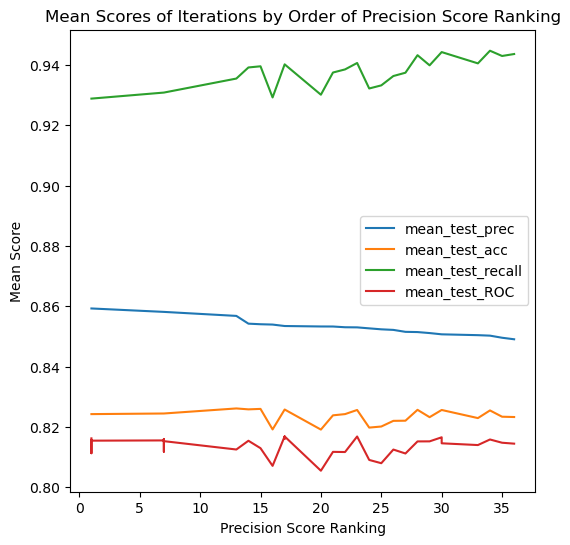

In [121]:
clf_df.sort_values(by='rank_test_prec', inplace=True)

score_vars = [col for col in clf_df.columns if ('mean_test' in col)]

fig, ax = plt.subplots(figsize=(6,6));

for i, col in enumerate(score_vars):
    ax.plot(clf_df.rank_test_prec, clf_df[col], label=col)

ax.set_xlabel('Precision Score Ranking');
ax.set_ylabel('Mean Score');
ax.set_title('Mean Scores of Iterations by Order of Precision Score Ranking');
ax.legend();

Since we didn't improve on our base model, let's try a different modeling method.

### Model 3

For this model will try using gradient boosting with XGBoost. Boosting is an iterative method that starts by building a weak model, and learning from it. This process is repeated until a stopping condition is met and our model is formed.

In [ ]:
# Instantiate XGBClassifier
xgb_clf= XGBClassifier()

param_grid = {
    'learning_rate': [0.1, 0.2, .3],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

# Old work, working up to it

In [ ]:
# # Saves X_train_mod to pickle file for ease to reload
# with open('data/temp_pickle_files/X_train_mod.pickle', 'wb') as f:
#     pickle.dump(X_train_mod, f)

In [ ]:
# # Opens X_train_mod pickle file
# with open('data/temp_pickle_files/X_train_mod.pickle', 'rb') as f:
#     X_train_mod = pickle.load(f)

## References

[1] <a id='h1n1_cdc_article' href='https://www.cdc.gov/flu/pandemic-resources/2009-h1n1-pandemic.html'>https://www.cdc.gov/flu/pandemic-resources/2009-h1n1-pandemic.html</a>

[2] <a id='About the National Immunization Survery' href="https://webarchive.loc.gov/all/20140511031000/http://www.cdc.gov/nchs/nis/about_nis.htm#h1n1">https://webarchive.loc.gov/all/20140511031000/http://www.cdc.gov/nchs/nis/about_nis.htm#h1n1</a>

[3] <a href='https://www.drivendata.org/competitions/66/flu-shot-learning/data/'>https://www.drivendata.org/competitions/66/flu-shot-learning/data/</a>

[4] <a id='Missing Data Imputation using Regression' href='https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression'>https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression</a>

# Code Testing

In [ ]:
# ohe.get_feature_names(X_train_imp.drop(missing_columns, axis=1).columns)

# Wrote but not forgotten

possible add backs later

In [ ]:
def quick_feature_info(feature, target):
    '''
    Prints out dataframe resembling a confusion matrix, with totals included
    '''

    ones = pd.Series(np.ones(feature.shape[0]), name='filler')
    temp_df = pd.concat([target, feature, ones], axis=1).dropna()
    total = temp_df.shape[0]
    df = pd.crosstab(temp_df[target.name], temp_df[feature.name], normalize=True)
    stats.chi2_contingency(df)[1]
    column_tot = pd.Series(df.sum(), name='total')
    df = df.append(column_tot)
    row_tot = pd.Series(df.sum(axis=1), name='total')
    df = pd.concat([df, row_tot], axis=1)

    
    display(df)
    print(f'{target.name} vs. {feature.name}: Total of {total} non null combinations.')
    print('Chi2 score: {:.5E}'.format(chi2))

In [ ]:
# features_of_interest = ['h1n1_concern', 
#                         'h1n1_knowledge', 
#                         'doctor_recc_h1n1', 
#                         'chronic_med_condition', 
#                         'health_worker', 
#                         'age_group', 
#                         'education']

# for feature in features_of_interest:
#     quick_feature_info(X[feature], y)
#     print(f'{feature}\n')

In [ ]:
# option for second dataframe needs to be fixed, combinations iterates through all columns of dataframe
# which is not the intention, need to set up 3 sets and perform combinations
# 1. shared features between two inputed dataframes
# 2. unique columns features in features DataFrame handled iterativly with target dataframe
# 3. Same for unique features in target DataFrame with features dataframe
# May be best to create individual function handling one feature with a dataframe as in the pd.series branch of if statement

# def ordered_chi2(features, target='features', ascending=True, alpha=None):
#     '''
#     Returnes the ordered chi2 P-values between each feature and the target variable or variables
    
#     Inputs: features = Dataframe of features
#             target = DataFrame or Series of features or target variable, 
#                      features with different entries can't share a name
#                      default = 'features' which results in finding relationships
#                      inside features DataFrame
#             ascending = Determines order, default value = True
#             alpha = Chi2 Pvalue threshold for which features get returned.
#                         Returns all features with a Pvalue<=alpha,
#                         default = None so all features are returned
            
#     Output: Dataframe containing ordered P-values
#     '''
    
#     df = pd.DataFrame(columns=['pair', 'Pvalue'])
                
#     if isinstance(target, pd.DataFrame):
#         feature_cols = set(features.columns)
#         target_cols = set(target.columns)
#         add_target_cols = target_cols - feature_cols
#         col_set = feature_cols.union(add_target_cols)
#         temp_df = pd.concat([features, target[add_target_cols]])
#         combs = combinations(col_set, 2)
        
#         for comb in combs:
#             temp_dict={}
#             temp_dict['pair'] = [comb]
#             temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(temp_df[comb[0]], temp_df[comb[1]]))[1]
#             df = df.append(temp_dict, ignore_index=True)
    
#     elif isinstance(target, pd.Series):
#         for col in features.columns:
#             temp_dict={}
#             temp_dict['pair'] = [target.name, col]
#             temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(target, features[col]))[1]
#             df = df.append(temp_dict, ignore_index=True)
    
#     elif target == 'features':
#         combs = combinations(features.columns, 2)
#         for comb in combs:
#             temp_dict={}
#             temp_dict['pair'] = [comb]
#             temp_dict['Pvalue'] = stats.chi2_contingency(pd.crosstab(features[comb[0]], features[comb[1]]))[1]
#             df = df.append(temp_dict, ignore_index=True)
        
#     else:
#         sys.exit('''Incorrect input for parameter target.
#         Parameter only accepts types pd.DataFrame, pd.Series, or left to default value.''')        
    
#     if alpha == None:
#         return df.sort_values(by='Pvalue', ascending=ascending)
#     else:
#         return df[df.Pvalue <= alpha].sort_values(by='Pvalue', ascending=ascending)

In [ ]:
# Grabs numberical columns from training set
X_train_num = X_train_mod.select_dtypes(include=['int64', 'float64']).copy()

def scatter_plots(X, n_cols, y='index'):
    '''
    Creates scatter plots for each feature in X against y
    Handles missing values of type Nan 
    
    Inputs: X = dataframe to have features plotted
            y = dataseries to be plotted against,
                default=index
            ncols = number of columns for figure
    Output: [# of features//ncols, ncols] sized figure of scatterplots
    '''
#     Calculates number of rows in figure
    n_rows = (X.shape[1]//n_cols)+1
    
#     Creates figure
    fig, axes = plt.subplots(figsize = (n_cols*5, n_rows*5),
                                  ncols=n_cols,
                                  nrows=n_rows);
#     Plots individual scatter plots
    for i, col in enumerate(X.columns):
        if type(y) == str:
            ind = range(X[col].notna().sum())
            axes[i//n_cols, i%n_cols].scatter(ind, X[col].dropna());
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y}');
        else:
            temp_df = pd.concat([X[col], y], axis=1).dropna()
            axes[i//n_cols, i%n_cols].scatter(temp_df.iloc[:,1], temp_df.iloc[:,0]);
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y.name}');
                        